# 目标：使用 ResNet18 在 CIFAR-10 上训练一个高精度分类器（80%+）

我们会做：

① 数据增强（RandomCrop、HorizontalFlip）
② Normalize（正式工程风格）
③ 使用 预训练的 ResNet18
④ 冻结部分层 → 微调（Finetune）
⑤ 训练与验证曲线
⑥ 输出混淆矩阵

一、导入库并设置 GPU

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
# from torchvision.models import resnet18
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# 检查 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

True
NVIDIA GeForce RTX 3090
Using device: cuda


二、数据增强 + Normalize

这是工程级别的 CIFAR10 规范增强方式：

In [62]:
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465),
#                          (0.2023, 0.1994, 0.2010)),
# ])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 随机平移
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])


# 三、下载数据（一次自动下载）

In [63]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)

classes = trainset.classes


Files already downloaded and verified
Files already downloaded and verified


# 四、构建 ResNet18 模型（更复杂的结构）
使用预训练 ImageNet 权重
✔ 修改最后一层
✔ 冻结前面的卷积层进行微调

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = resnet18(pretrained=True)
# 加载预训练权重（替代 pretrained=True）
# weights = ResNet18_Weights.DEFAULT
weights=ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
# 冻结前 7 层
for name, param in model.named_parameters():
    if "layer4" not in name:   # 只训练最后两层
        param.requires_grad = False

# 修改 conv1 和 maxpool，适应 CIFAR10
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()  # 去掉原来的 MaxPool

# 修改最后的全连接层（1000 -> 10 类）
# model.fc = nn.Linear(512, 10)
model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # 每3个epoch lr缩小10倍

增强封装：Mixup + CutMix 自动切换
假设：

图片 A 是猫（标签 0）

图片 B 是狗（标签 1）

CutMix 会取 B 的一个矩形区域贴到 A 上：

+---------------------+
|         A           |
|   +-----------+     |
|   |     B     |     |
|   | (patch)   |     |
|   +-----------+     |
+---------------------+


然后标签改为按面积混合：

如果 B 的 patch 占图像 30%：

label = 0.7 * 猫 + 0.3 * 狗

In [ ]:
import torch
import numpy as np
import random

def rand_bbox(size, lam):
    """size: (B, C, H, W)"""
    W = size[2]
    H = size[3]

    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform random center
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    y2 = np.clip(cy + cut_h // 2, 0, H)

    return x1, y1, x2, y2


def apply_mixup_cutmix(x, y, alpha=1.0, mix_prob=0.5):
    """
    x: images  (B,C,H,W)
    y: labels  (B)
    alpha: Beta 分布参数
    mix_prob: 进行 mixup/cutmix 的概率（不是 100% 每个 batch 都要）
    """
    if random.random() > mix_prob:
        return x, y, None, None, 1.0  # 不做增强

    # 是否用 Mixup 还是 CutMix
    use_cutmix = random.random() < 0.5

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    lam = np.random.beta(alpha, alpha)

    if not use_cutmix:
        # ===== Mixup =====
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, index, lam

    else:
        # ===== CutMix =====
        x1, y1, x2, y2 = rand_bbox(x.size(), lam)
        mixed_x = x.clone()
        # mixed_x[:, :, x1:x2, y1:y2] = x[index, :, x1:x2, y1:y2]
        mixed_x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]

        # 修正 lambda 为实际面积比例
        lam = 1 - ((x2 - x1) * (y2 - y1) / (x.size(-1) * x.size(-2)))

        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, index, lam


In [82]:
def apply_mixup_cutmix(x, y, alpha=1.0, mix_prob=0.8):
    if np.random.rand() > mix_prob:
        # 不做增强
        return x, y, None, None, 1.0

    # 采样 lambda
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    y_a = y
    y_b = y[index]

    # 随机决定是 Mixup 还是 CutMix
    if np.random.rand() < 0.5:
        # === Mixup ===
        mixed_x = lam * x + (1 - lam) * x[index]
        return mixed_x, y_a, y_b, index, lam
    else:
        # === CutMix ===
        _, H, W = x.size(1), x.size(2), x.size(3)
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        x1 = np.clip(cx - cut_w // 2, 0, W)
        x2 = np.clip(cx + cut_w // 2, 0, W)
        y1 = np.clip(cy - cut_h // 2, 0, H)
        y2 = np.clip(cy + cut_h // 2, 0, H)

        mixed_x = x.clone()
        mixed_x[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]

        lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))

        return mixed_x, y_a, y_b, index, lam
# 修正后的训练循环
def mixup_cutmix_criterion(pred, y_a, y_b, lam, criterion):
    """混合增强的损失函数计算"""
    if y_b is not None:
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    else:
        return criterion(pred, y_a)

# 训练模型

In [80]:
train_losses = []

for epoch in range(200):  
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # === 混合增强 ===
        inputs, y_a, y_b, index, lam = apply_mixup_cutmix(
            inputs, labels, alpha=1.0, mix_prob=0.8
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        if y_b is not None:
            loss = lam * criterion(outputs, y_a) + (1 - lam) * criterion(outputs, y_b)
        else:
            loss = criterion(outputs, labels)
        # loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f}")
    scheduler.step()  # 更新学习率
    
print("Training done.")


Epoch 1 | Loss: 1.2103
Epoch 2 | Loss: 1.2420
Epoch 3 | Loss: 1.2605
Epoch 4 | Loss: 1.2504
Epoch 5 | Loss: 1.2558
Epoch 6 | Loss: 1.2348
Epoch 7 | Loss: 1.2640
Epoch 8 | Loss: 1.1855
Epoch 9 | Loss: 1.2243
Epoch 10 | Loss: 1.2373
Epoch 11 | Loss: 1.1928
Epoch 12 | Loss: 1.2364
Epoch 13 | Loss: 1.1880
Epoch 14 | Loss: 1.2046
Epoch 15 | Loss: 1.1867
Epoch 16 | Loss: 1.2733
Epoch 17 | Loss: 1.2083
Epoch 18 | Loss: 1.1951
Epoch 19 | Loss: 1.1918
Epoch 20 | Loss: 1.1760
Epoch 21 | Loss: 1.2478
Epoch 22 | Loss: 1.1729
Epoch 23 | Loss: 1.1820
Epoch 24 | Loss: 1.1891
Epoch 25 | Loss: 1.2009
Epoch 26 | Loss: 1.1653
Epoch 27 | Loss: 1.1960
Epoch 28 | Loss: 1.2231
Epoch 29 | Loss: 1.1787
Epoch 30 | Loss: 1.1906
Epoch 31 | Loss: 1.1633
Epoch 32 | Loss: 1.1716
Epoch 33 | Loss: 1.1821
Epoch 34 | Loss: 1.1866
Epoch 35 | Loss: 1.1688
Epoch 36 | Loss: 1.1621
Epoch 37 | Loss: 1.1962
Epoch 38 | Loss: 1.1836
Epoch 39 | Loss: 1.1834
Epoch 40 | Loss: 1.1381
Epoch 41 | Loss: 1.1856
Epoch 42 | Loss: 1.1535
E

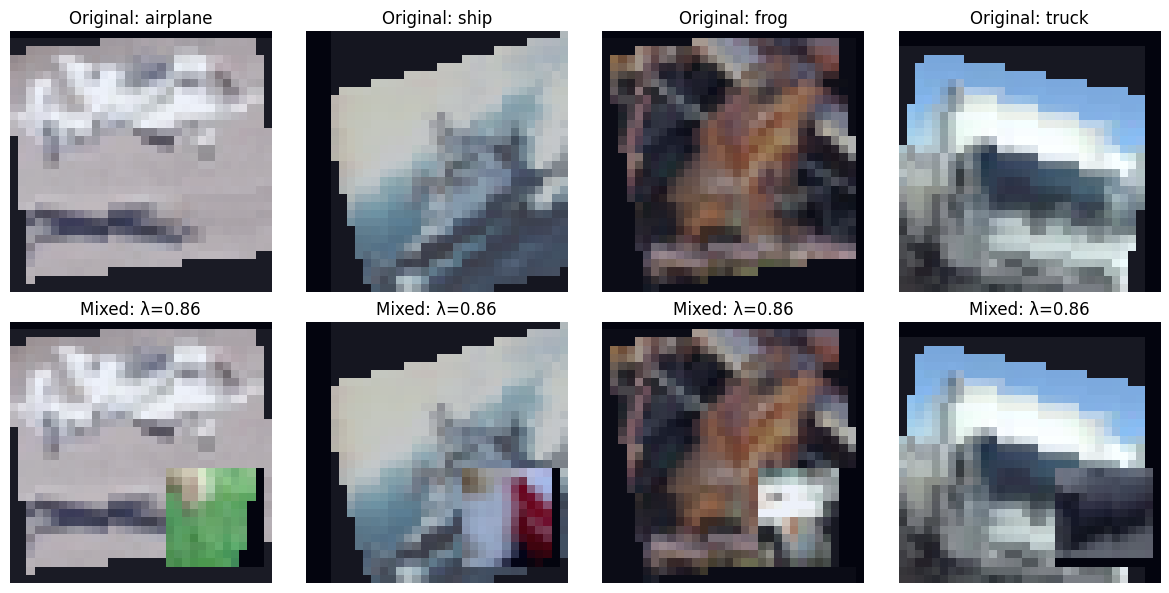

In [79]:
def visualize_mixup_cutmix():
    """可视化混合增强效果"""
    import matplotlib.pyplot as plt
    
    # 获取一个batch的数据
    inputs, labels = next(iter(trainloader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # 应用混合增强
    mixed_inputs, y_a, y_b, index, lam = apply_mixup_cutmix(inputs, labels)
    
    # 可视化
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    
    for i in range(4):
        # 原始图像
        orig_img = inputs[i].cpu().permute(1, 2, 0).numpy()
        orig_img = np.clip(orig_img * 0.2 + 0.5, 0, 1)  # 反标准化
        axes[0, i].imshow(orig_img)
        axes[0, i].set_title(f'Original: {classes[labels[i].item()]}')
        axes[0, i].axis('off')
        
        # 增强后图像
        mixed_img = mixed_inputs[i].cpu().permute(1, 2, 0).numpy()
        mixed_img = np.clip(mixed_img * 0.2 + 0.5, 0, 1)
        axes[1, i].imshow(mixed_img)
        if y_b is not None:
            title = f'Mixed: λ={lam:.2f}'
        else:
            title = 'No augmentation'
        axes[1, i].set_title(title)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 运行可视化
visualize_mixup_cutmix()

# 六、绘制训练 Loss 曲线

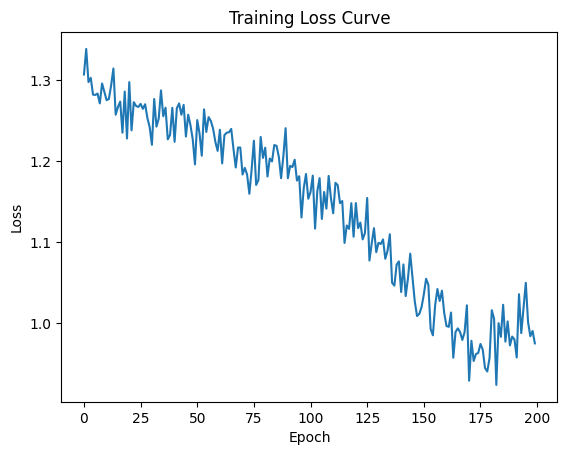

In [70]:
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# 七、测试模型精度

In [83]:
model.eval()
correct = 0
total = 0

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu())
        all_preds.extend(predicted.cpu())

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 85.91%


In [59]:
import os

# 查看当前工作目录
print("当前工作目录:", os.getcwd())
torch.save(model.state_dict(), 'best_resnet18_cifar10.pth')
# 查看文件是否保存成功
if os.path.exists('best_resnet18_cifar10.pth'):
    file_size = os.path.getsize('best_resnet18_cifar10.pth') / (1024 * 1024)  # MB
    print(f"模型文件已保存: {os.path.abspath('best_resnet18_cifar10.pth')}")
    print(f"文件大小: {file_size:.2f} MB")
else:
    print("模型文件未找到")
    

当前工作目录: /home/recon
模型文件已保存: /home/recon/best_resnet18_cifar10.pth
文件大小: 42.70 MB


八、混淆矩阵（可视化分类错误）

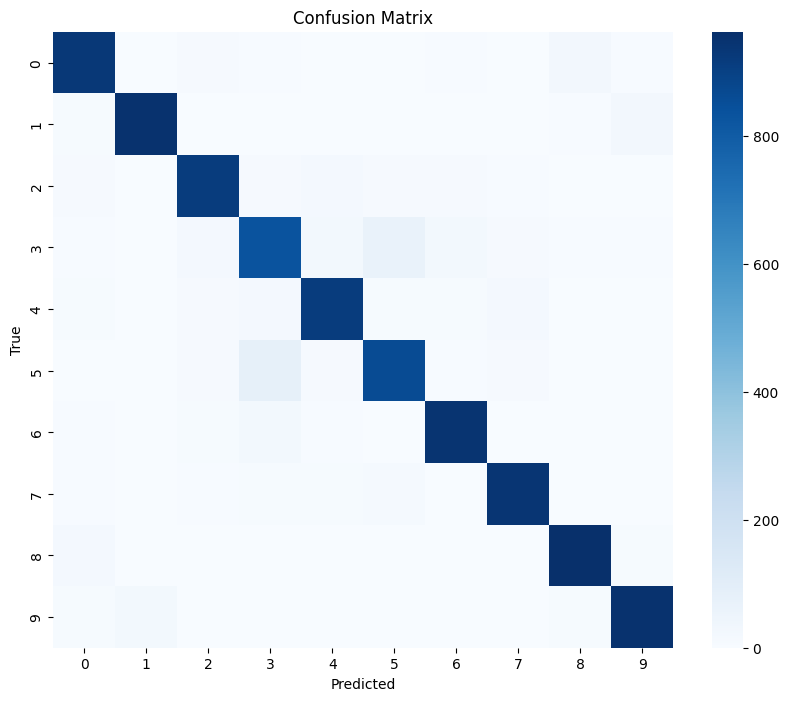

In [60]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# 九、展示一些预测结果

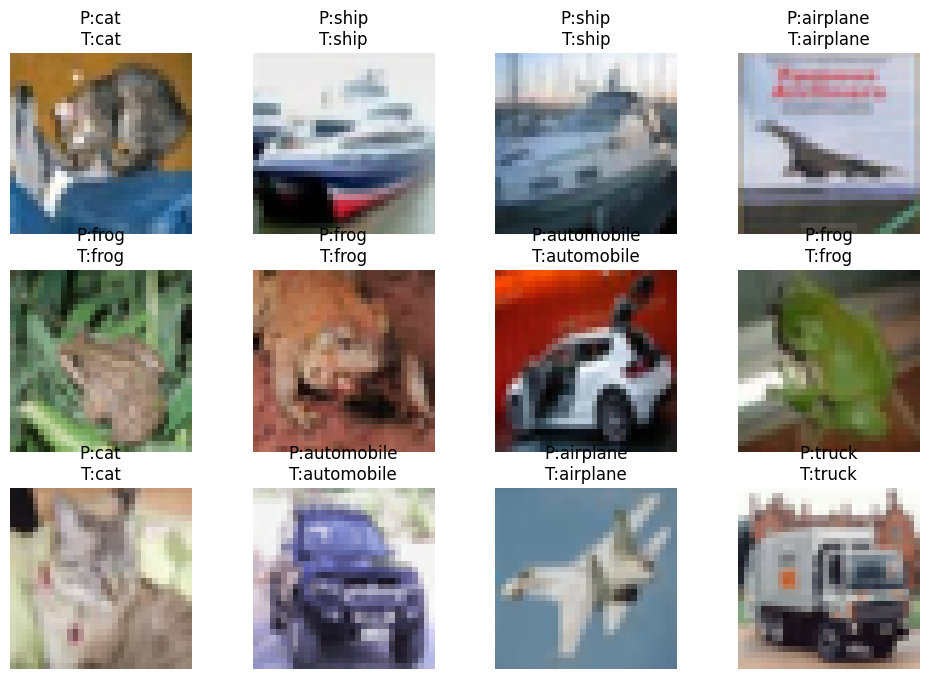

In [61]:
dataiter = iter(testloader)
images, labels = next(dataiter)

outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

images = images * torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1) + \
         torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)

fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(f"P:{classes[predicted[i]]}\nT:{classes[labels[i]]}")
    ax.axis("off")
plt.show()


In [55]:
# 检查模型结构
print("模型结构检查:")
print(f"第一层卷积: {model.conv1}")
print(f"全连接层输入特征数: {model.fc.in_features if hasattr(model.fc, 'in_features') else '检查fc层结构'}")

# 检查数据加载
for images, labels in trainloader:
    print(f"输入图像形状: {images.shape}")  # 应该是[128, 3, 32, 32]
    print(f"标签形状: {labels.shape}")      # 应该是[128]
    break

模型结构检查:
第一层卷积: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
全连接层输入特征数: 512
输入图像形状: torch.Size([128, 3, 32, 32])
标签形状: torch.Size([128])
